# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
http://www.vahidmoosavi.com

https://github.com/sevamoo/sompy

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

from sklearn.preprocessing import StandardScaler

import os
import xarray as xr

import datetime

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
backend module://ipykernel.pylab.backend_inline version unknown


In [114]:
os.getcwd()

'C:\\Users\\goyetc\\SOMPY'

#### Prepare Data for Model
* Import data, view basic characteristics
* normalize
* Observe 2d abstraction of SOM results
* Extract cluster designations








In [2]:
DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
#DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [4]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['pCO2']['pCO2']], axis=1)

In [5]:
SOM_input.head()

,time,ylat,xlon,SSS,MLD,SST,pCO2
0,1982-01-16 12:00:00,-77.5,179.5,34.000992,16.192860,1.648732,151.525853
1,1982-01-16 12:00:00,-77.5,180.5,33.941429,15.115437,1.528921,150.330599
2,1982-01-16 12:00:00,-77.5,181.5,33.863464,14.071844,1.350243,148.500409
3,1982-01-16 12:00:00,-77.5,182.5,33.775764,13.072312,1.119088,146.198458
4,1982-01-16 12:00:00,-77.5,183.5,33.691376,12.333377,0.865820,143.769723


In [6]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

### Note above: 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

In [131]:
means = SOM_input.groupby(['ylat','xlon'], as_index=False).mean()

In [132]:
means.shape

(41035, 6)

In [133]:
means.head()
#SOM_input.head()

,ylat,xlon,SSS,MLD,SST,pCO2
0,-77.5,179.5,34.316242,237.387344,-1.257135,270.162289
1,-77.5,180.5,34.295708,236.778397,-1.274530,269.626504
2,-77.5,181.5,34.269802,234.275604,-1.300513,268.901123
3,-77.5,182.5,34.241173,226.481583,-1.334906,268.001064
4,-77.5,183.5,34.213009,211.385742,-1.375007,266.963243


# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [134]:
#Prepare data

#log(MLD)
means[['MLD']] = means[['MLD']].apply(np.log)

#scale
ss = StandardScaler().fit_transform(means[['SSS','SST','MLD','pCO2']])

In [135]:
#tuning parameters
#research suggests M = 5*sqrt(N) is a good choice for number of neurons
M = 5*np.sqrt(ss.shape[0])
M
#insert source

1012.8548760804778

In [136]:
m=int(np.sqrt(M))
m

31

### Notes on SOM tuning
* testing suggests pca is faster than random init but limits # of epochs/trainlen internal to SOM engine
* batch faster than sequential

In [138]:
mapsize = [31,31]
som = sompy.SOMFactory.build(ss, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', 
                             initialization='random', neighborhood='gaussian', 
                             training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=5, verbose='info',train_rough_len=10, train_finetune_len=20, )  # verbose='debug' will print more, and verbose=None wont print anything
#sm.train(n_job=5, verbose='info', train_rough_len=20, train_finetune_len=50)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 11.000000 , radius_final: 1.833333, trainlen: 10

 epoch: 1 ---> elapsed time:  0.397000, quantization error: 0.841963

 epoch: 2 ---> elapsed time:  0.400000, quantization error: 1.511664

 epoch: 3 ---> elapsed time:  0.383000, quantization error: 1.088076

 epoch: 4 ---> elapsed time:  0.391000, quantization error: 0.948117

 epoch: 5 ---> elapsed time:  0.403000, quantization error: 0.857559

 epoch: 6 ---> elapsed time:  0.411000, quantization error: 0.784697

 epoch: 7 ---> elapsed time:  0.410000, quantization error: 0.724420

 epoch: 8 ---> elapsed time:  0.412000, quantization error: 0.657222

 epoch: 9 ---> elapsed time:  0.425000, quantization error: 0.572417

 epoch: 10 ---> elapsed time:  0.387000, quantization error: 0.478678

 Finetune training...
 radius_ini: 2.583333 , radius_final: 1.000000, trainlen: 20

 epoch: 1 ---> elapsed time:  0.501000, quantization error: 0.384026

 epo

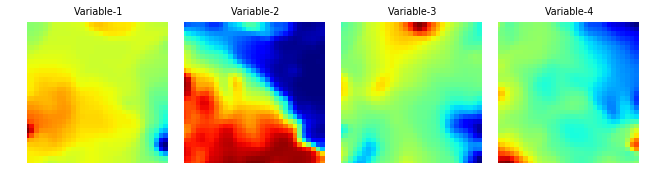

In [143]:
v = sompy.mapview.View2DPacked(40, 40, '',text_size=8)  
v.show(som, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default

In [144]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(40,40, 'test',text_size=8)  
#first you can do clustering. Currently only K-means on top of the trained som
cl_5 = som.cluster(n_clusters=5)
# print cl
getattr(som, 'cluster_labels')

array([2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2,

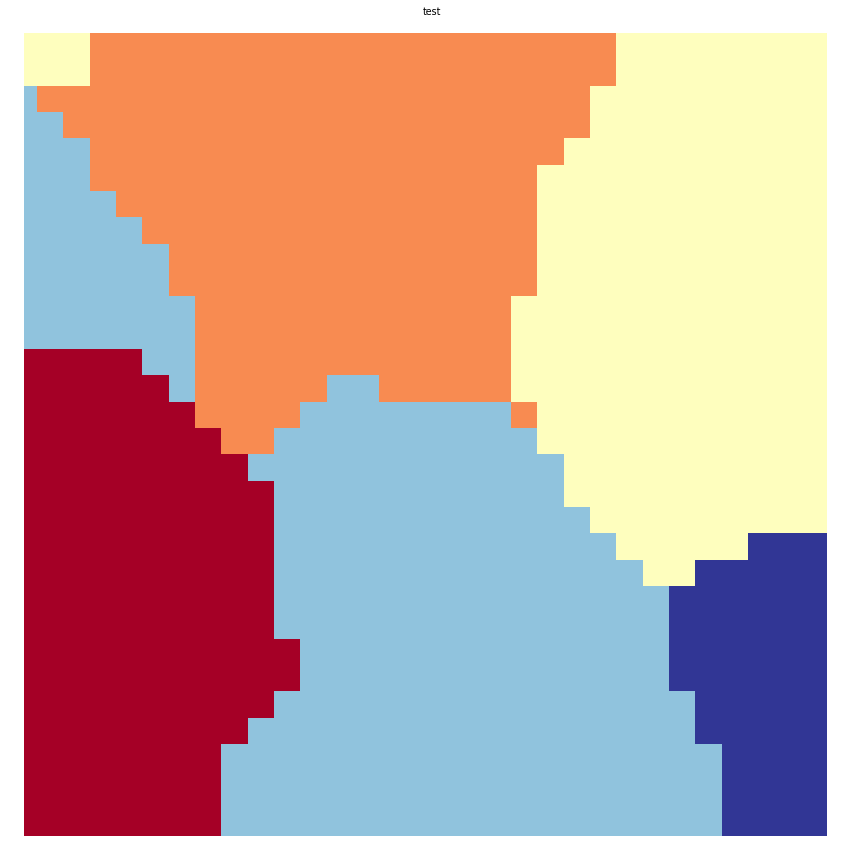

In [145]:
v.show(som, what='cluster')

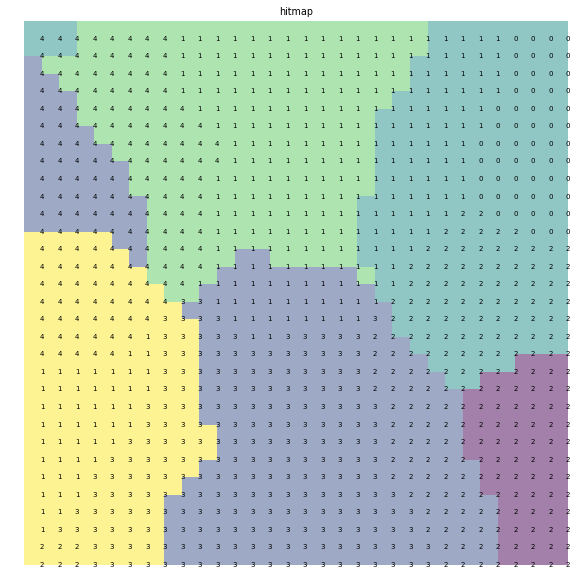

In [146]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

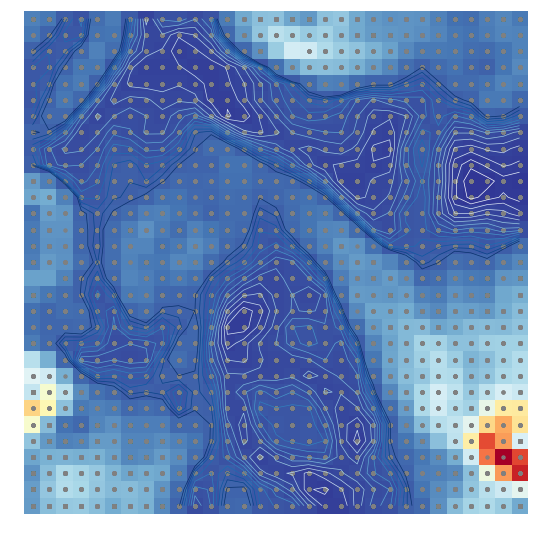

In [147]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=2, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)


# TO DO
* Interpret hitmap and u-matrix more.. pretty but what can be learned?
* Try with other combos, e.g., No Chl or log(MLD) per Landschutzer
* Perform tuning exercise to choose model with lowest error
* Validate conversion of SOM results back to cluster designation for raw data (e.g., translation of neuron results to all raw data points based on centroid/BMU value)
* Validate that "clustering" method described using k-means above, post model-build, is what we're looking for

In [148]:
%matplotlib inline
import math
import glob
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import random
import matplotlib
from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

In [149]:
import random

In [150]:
m,5*m,(5*m)**2

(31, 155, 24025)

In [151]:
names = ['SSS','SST','MLD','pCO2']

In [152]:
# Train the model with different parameters. The more, the better. Each iteration is stored in disk for further study 
# 20 models built, evaluated for topographic error

for i in range(10): 
    sm = sompy.SOMFactory().build(ss, 
                            mapsize=[random.choice(list(range(m/5,5*m))), 
                                     random.choice(list(range(m/5,5*m)))], 
                            normalization = 'var', initialization='pca', 
                            component_names=names, lattice='rect')
    sm.train(n_job=4, 
            verbose='info', 
            train_rough_len=20, 
            train_finetune_len=40)
    
    joblib.dump(sm, "mean_model_{}.joblib".format(i))

 Training...
 pca_linear_initialization took: 0.062000 seconds
 Rough training...
 radius_ini: 14.000000 , radius_final: 3.500000, trainlen: 20

 epoch: 1 ---> elapsed time:  0.388000, quantization error: 0.925585

 epoch: 2 ---> elapsed time:  0.271000, quantization error: 1.299060

 epoch: 3 ---> elapsed time:  0.366000, quantization error: 1.062953

 epoch: 4 ---> elapsed time:  0.265000, quantization error: 1.000346

 epoch: 5 ---> elapsed time:  0.367000, quantization error: 0.979633

 epoch: 6 ---> elapsed time:  0.287000, quantization error: 0.961109

 epoch: 7 ---> elapsed time:  0.356000, quantization error: 0.941507

 epoch: 8 ---> elapsed time:  0.282000, quantization error: 0.920307

 epoch: 9 ---> elapsed time:  0.379000, quantization error: 0.898139

 epoch: 10 ---> elapsed time:  0.278000, quantization error: 0.874264

 epoch: 11 ---> elapsed time:  0.259000, quantization error: 0.847946

 epoch: 12 ---> elapsed time:  0.268000, quantization error: 0.822253

 epoch: 13 -

 epoch: 30 ---> elapsed time:  0.804000, quantization error: 0.199398

 epoch: 31 ---> elapsed time:  0.785000, quantization error: 0.197629

 epoch: 32 ---> elapsed time:  0.796000, quantization error: 0.195855

 epoch: 33 ---> elapsed time:  0.780000, quantization error: 0.194063

 epoch: 34 ---> elapsed time:  0.797000, quantization error: 0.191998

 epoch: 35 ---> elapsed time:  0.718000, quantization error: 0.190084

 epoch: 36 ---> elapsed time:  0.830000, quantization error: 0.188245

 epoch: 37 ---> elapsed time:  0.694000, quantization error: 0.186475

 epoch: 38 ---> elapsed time:  0.789000, quantization error: 0.184708

 epoch: 39 ---> elapsed time:  0.818000, quantization error: 0.182923

 epoch: 40 ---> elapsed time:  0.781000, quantization error: 0.181101

 Final quantization error: 0.181101
 train took: 48.289000 seconds
 Training...
 pca_linear_initialization took: 0.109000 seconds
 Rough training...
 radius_ini: 16.000000 , radius_final: 4.000000, trainlen: 20

 epoch:

 epoch: 17 ---> elapsed time:  3.963000, quantization error: 0.269231

 epoch: 18 ---> elapsed time:  3.997000, quantization error: 0.264195

 epoch: 19 ---> elapsed time:  4.093000, quantization error: 0.259134

 epoch: 20 ---> elapsed time:  3.968000, quantization error: 0.253948

 epoch: 21 ---> elapsed time:  3.982000, quantization error: 0.248695

 epoch: 22 ---> elapsed time:  3.981000, quantization error: 0.243332

 epoch: 23 ---> elapsed time:  4.021000, quantization error: 0.237849

 epoch: 24 ---> elapsed time:  3.982000, quantization error: 0.232233

 epoch: 25 ---> elapsed time:  4.118000, quantization error: 0.226628

 epoch: 26 ---> elapsed time:  4.005000, quantization error: 0.221131

 epoch: 27 ---> elapsed time:  4.044000, quantization error: 0.215634

 epoch: 28 ---> elapsed time:  4.023000, quantization error: 0.210055

 epoch: 29 ---> elapsed time:  4.040000, quantization error: 0.204393

 epoch: 30 ---> elapsed time:  4.042000, quantization error: 0.198768

 epoch

 epoch: 5 ---> elapsed time:  2.854000, quantization error: 0.218925

 epoch: 6 ---> elapsed time:  2.879000, quantization error: 0.216559

 epoch: 7 ---> elapsed time:  2.850000, quantization error: 0.214285

 epoch: 8 ---> elapsed time:  2.968000, quantization error: 0.212104

 epoch: 9 ---> elapsed time:  2.896000, quantization error: 0.209918

 epoch: 10 ---> elapsed time:  2.850000, quantization error: 0.207829

 epoch: 11 ---> elapsed time:  2.849000, quantization error: 0.205735

 epoch: 12 ---> elapsed time:  2.890000, quantization error: 0.203646

 epoch: 13 ---> elapsed time:  2.751000, quantization error: 0.201543

 epoch: 14 ---> elapsed time:  2.849000, quantization error: 0.199447

 epoch: 15 ---> elapsed time:  2.869000, quantization error: 0.197407

 epoch: 16 ---> elapsed time:  2.865000, quantization error: 0.195265

 epoch: 17 ---> elapsed time:  2.977000, quantization error: 0.193192

 epoch: 18 ---> elapsed time:  2.921000, quantization error: 0.191140

 epoch: 19 

 epoch: 14 ---> elapsed time:  1.134000, quantization error: 0.434186

 epoch: 15 ---> elapsed time:  1.135000, quantization error: 0.411783

 epoch: 16 ---> elapsed time:  1.140000, quantization error: 0.389637

 epoch: 17 ---> elapsed time:  1.179000, quantization error: 0.367336

 epoch: 18 ---> elapsed time:  1.183000, quantization error: 0.344589

 epoch: 19 ---> elapsed time:  1.171000, quantization error: 0.321042

 epoch: 20 ---> elapsed time:  1.187000, quantization error: 0.296831

 Finetune training...
 radius_ini: 2.250000 , radius_final: 1.000000, trainlen: 40

 epoch: 1 ---> elapsed time:  1.178000, quantization error: 0.271386

 epoch: 2 ---> elapsed time:  1.177000, quantization error: 0.266657

 epoch: 3 ---> elapsed time:  1.143000, quantization error: 0.262135

 epoch: 4 ---> elapsed time:  1.182000, quantization error: 0.258198

 epoch: 5 ---> elapsed time:  1.171000, quantization error: 0.254744

 epoch: 6 ---> elapsed time:  1.156000, quantization error: 0.251474


 epoch: 2 ---> elapsed time:  3.918000, quantization error: 0.716377

 epoch: 3 ---> elapsed time:  3.796000, quantization error: 0.670653

 epoch: 4 ---> elapsed time:  3.828000, quantization error: 0.644429

 epoch: 5 ---> elapsed time:  3.916000, quantization error: 0.622568

 epoch: 6 ---> elapsed time:  3.811000, quantization error: 0.602759

 epoch: 7 ---> elapsed time:  3.836000, quantization error: 0.582993

 epoch: 8 ---> elapsed time:  3.820000, quantization error: 0.562798

 epoch: 9 ---> elapsed time:  3.836000, quantization error: 0.542021

 epoch: 10 ---> elapsed time:  4.568000, quantization error: 0.520954

 epoch: 11 ---> elapsed time:  4.912000, quantization error: 0.499980

 epoch: 12 ---> elapsed time:  4.074000, quantization error: 0.479011

 epoch: 13 ---> elapsed time:  3.815000, quantization error: 0.457646

 epoch: 14 ---> elapsed time:  4.144000, quantization error: 0.435909

 epoch: 15 ---> elapsed time:  4.039000, quantization error: 0.413686

 epoch: 16 ---

In [154]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./mean_model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

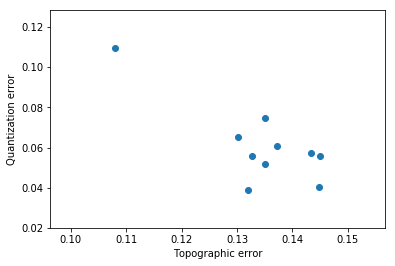

In [155]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

### From Original SOMtoolbox documentation
* http://www.cis.hut.fi/somtoolbox/package/docs2/som_quality.html

*     qe : Average distance between each data vector and its BMU.
       Measures map resolution.
*     te : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

In [158]:
res = []
for i, model_filepath in enumerate(models_pool):
    res.append({'model': model_filepath[2:14].strip('.'), 'topographical_error': e_top[i], 'quantization_error': e_q[i]})
    #res.append({'model': model_filepath, 'topographical_error': e_top[i], 'quantization_error': e_q[i]})
    #print(model_filepath)
    #name.append(model_filepath[3:10])
    #err_top.append(e_top[i])
    #err_quant.append(e_q[i])

results_df = pd.DataFrame(res)
results_df
#print(model_filepath,e_top[i],e_q[i])


,model,quantization_error,topographical_error
0,mean_model_0,0.109451,0.108078
1,mean_model_1,0.074850,0.135031
2,mean_model_2,0.038804,0.131912
3,mean_model_3,0.055653,0.145023
4,mean_model_4,0.057484,0.143317
5,mean_model_5,0.060559,0.137151
6,mean_model_6,0.040566,0.144828
7,mean_model_7,0.065201,0.130230
8,mean_model_8,0.051723,0.135080
9,mean_model_9,0.055868,0.132618


In [159]:
results_df.sort_values(['topographical_error'], ascending=True)

,model,quantization_error,topographical_error
0,mean_model_0,0.109451,0.108078
7,mean_model_7,0.065201,0.130230
2,mean_model_2,0.038804,0.131912
9,mean_model_9,0.055868,0.132618
1,mean_model_1,0.074850,0.135031
8,mean_model_8,0.051723,0.135080
5,mean_model_5,0.060559,0.137151
4,mean_model_4,0.057484,0.143317
6,mean_model_6,0.040566,0.144828
3,mean_model_3,0.055653,0.145023


#### Model 0 has the lowest topographic error so we will use these hyperparameters moving forward

In [160]:
#top_model = joblib.load('C:\\Users\goyetc\\SOMPY\\5_model_test_11_23\\model_2.joblib')
mean_best = joblib.load('C:\\Users\goyetc\\SOMPY\\mean_model_0.joblib')
mean_best.__dict__

In [162]:
mean_best.calculate_map_size('rect')


[29, 35]

In [ ]:
#note: mean_best initial radiuses: 14, 3.5

In [169]:
mean_best.__dict__

{'_bmu': array([[  5.62000000e+02,   5.62000000e+02,   5.62000000e+02, ...,
           2.30000000e+01,   2.30000000e+01,   2.30000000e+01],
        [  1.79329921e+00,   1.80683533e+00,   1.81591119e+00, ...,
           1.35550033e-02,   1.41659069e-02,   1.47852844e-02]]),
 '_component_names': [['SSS', 'SST', 'MLD', 'pCO2']],
 '_data': array([[ 0.18913603, -1.3459917 ,  3.41670057, -2.6790296 ],
        [ 0.17588447, -1.3475531 ,  3.41021886, -2.69762985],
        [ 0.15916678, -1.34988534,  3.38340523, -2.72281208],
        ..., 
        [-0.84256275, -1.39285668, -0.15187448, -1.19543379],
        [-0.84284339, -1.39285576, -0.15225229, -1.19487994],
        [-0.84312895, -1.39285485, -0.15263131, -1.19433144]]),
 '_dim': 4L,
 '_distance_matrix': array([[  0.00000000e+00,   1.00000000e+00,   4.00000000e+00, ...,
           1.19060000e+04,   1.21250000e+04,   1.23460000e+04],
        [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
           1.16890000e+04,   1.19060000e+0

In [163]:
mean_best.calculate_topographic_error()

0.10807846959912271

In [164]:
mean_best.calculate_quantization_error()

0.10945089303776113

## Observe effects of various training lengths on best model from above
* Note: first pass, same performance was not achieved as the randomly achieved best performance as before. Nevertheless, decent topographical perf and and quant perf achieved
* Also note below that various training times do not significantly improve topographical error, and quantization error is basically flat. Implies we can achieve reasonable mapping with low(ish) epochs of rough/fine tuning

In [179]:
map_best = mean_best.calculate_map_size('rect')
names = ['SSS','SST','MLD','pCO2']

for i in range(20): 
    sm = sompy.SOMFactory().build(ss, mapsize = map_best, mapshape = 'planar',
                            initialization='pca',
                            normalization = 'var', 
                            component_names=names, lattice='rect') 
    sm.train(n_job=4, 
             verbose='info', 
             train_rough_len=random.choice(list(range(20,40))),
             train_finetune_len=random.choice(list(range(40,100))),
             #train_rough_radiusin=14,
             #train_rough_radiusfin=3.5,
             #train_finetune_radiusin=3.5,
             #train_finetune_radiusfin=1
            ) 
    
    joblib.dump(sm, "model_mean_opt_r3_epochs_{}.joblib".format(i))

 Training...
 pca_linear_initialization took: 0.054000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 32

 epoch: 1 ---> elapsed time:  0.387000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.390000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.397000, quantization error: 0.654553

 epoch: 4 ---> elapsed time:  0.390000, quantization error: 0.631314

 epoch: 5 ---> elapsed time:  0.391000, quantization error: 0.614198

 epoch: 6 ---> elapsed time:  0.396000, quantization error: 0.601104

 epoch: 7 ---> elapsed time:  0.387000, quantization error: 0.589545

 epoch: 8 ---> elapsed time:  0.387000, quantization error: 0.578247

 epoch: 9 ---> elapsed time:  0.387000, quantization error: 0.567044

 epoch: 10 ---> elapsed time:  0.387000, quantization error: 0.555391

 epoch: 11 ---> elapsed time:  0.388000, quantization error: 0.543574

 epoch: 12 ---> elapsed time:  0.388000, quantization error: 0.531560

 epoch: 13 --

 epoch: 82 ---> elapsed time:  0.389000, quantization error: 0.221726

 epoch: 83 ---> elapsed time:  0.392000, quantization error: 0.221453

 epoch: 84 ---> elapsed time:  0.396000, quantization error: 0.221170

 epoch: 85 ---> elapsed time:  0.402000, quantization error: 0.220880

 epoch: 86 ---> elapsed time:  0.391000, quantization error: 0.220592

 epoch: 87 ---> elapsed time:  0.398000, quantization error: 0.220300

 epoch: 88 ---> elapsed time:  0.391000, quantization error: 0.219984

 epoch: 89 ---> elapsed time:  0.390000, quantization error: 0.219694

 epoch: 90 ---> elapsed time:  0.390000, quantization error: 0.219369

 Final quantization error: 0.219369
 train took: 51.657000 seconds
 Training...
 pca_linear_initialization took: 0.060000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 35

 epoch: 1 ---> elapsed time:  0.387000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.393000, quantization error: 0.708758

 epoch: 3 

 epoch: 69 ---> elapsed time:  0.394000, quantization error: 0.224983

 epoch: 70 ---> elapsed time:  0.395000, quantization error: 0.224653

 epoch: 71 ---> elapsed time:  0.395000, quantization error: 0.224329

 epoch: 72 ---> elapsed time:  0.394000, quantization error: 0.224020

 epoch: 73 ---> elapsed time:  0.386000, quantization error: 0.223703

 epoch: 74 ---> elapsed time:  0.396000, quantization error: 0.223383

 epoch: 75 ---> elapsed time:  0.395000, quantization error: 0.223073

 epoch: 76 ---> elapsed time:  0.394000, quantization error: 0.222682

 epoch: 77 ---> elapsed time:  0.395000, quantization error: 0.222333

 epoch: 78 ---> elapsed time:  0.394000, quantization error: 0.222017

 epoch: 79 ---> elapsed time:  0.397000, quantization error: 0.221696

 epoch: 80 ---> elapsed time:  0.403000, quantization error: 0.221374

 epoch: 81 ---> elapsed time:  0.395000, quantization error: 0.221073

 epoch: 82 ---> elapsed time:  0.394000, quantization error: 0.220774

 epoch

 epoch: 60 ---> elapsed time:  0.393000, quantization error: 0.222064

 epoch: 61 ---> elapsed time:  0.394000, quantization error: 0.221645

 epoch: 62 ---> elapsed time:  0.394000, quantization error: 0.221228

 epoch: 63 ---> elapsed time:  0.393000, quantization error: 0.220825

 epoch: 64 ---> elapsed time:  0.394000, quantization error: 0.220415

 Final quantization error: 0.220415
 train took: 41.051000 seconds
 Training...
 pca_linear_initialization took: 0.071000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 30

 epoch: 1 ---> elapsed time:  0.395000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.394000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.496000, quantization error: 0.653962

 epoch: 4 ---> elapsed time:  0.399000, quantization error: 0.630058

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.612299

 epoch: 6 ---> elapsed time:  0.395000, quantization error: 0.598563

 epoch: 7 --->

 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 36

 epoch: 1 ---> elapsed time:  0.390000, quantization error: 0.895949

 epoch: 2 ---> elapsed time:  0.394000, quantization error: 0.708758

 epoch: 3 ---> elapsed time:  0.400000, quantization error: 0.655532

 epoch: 4 ---> elapsed time:  0.506000, quantization error: 0.633385

 epoch: 5 ---> elapsed time:  0.407000, quantization error: 0.617296

 epoch: 6 ---> elapsed time:  0.398000, quantization error: 0.605288

 epoch: 7 ---> elapsed time:  0.393000, quantization error: 0.594954

 epoch: 8 ---> elapsed time:  0.394000, quantization error: 0.585000

 epoch: 9 ---> elapsed time:  0.394000, quantization error: 0.575062

 epoch: 10 ---> elapsed time:  0.394000, quantization error: 0.565104

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.554767

 epoch: 12 ---> elapsed time:  0.393000, quantization error: 0.544426

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.533683

 epoc

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.492000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.457810

 epoch: 19 ---> elapsed time:  0.415000, quantization error: 0.445791

 epoch: 20 ---> elapsed time:  0.400000, quantization error: 0.433663

 epoch: 21 ---> elapsed time:  0.502000, quantization error: 0.421378

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.408959

 epoch: 23 ---> elapsed time:  0.402000, quantization error: 0.396386

 epoch: 24 ---> elapsed time:  0.394000, quantization error: 0.383763

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.371039

 epoch: 26 ---> elapsed time:  0.394000, quantization error: 0.358279

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.345440

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.332546

 epoch

 epoch: 6 ---> elapsed time:  0.395000, quantization error: 0.602259

 epoch: 7 ---> elapsed time:  0.395000, quantization error: 0.591004

 epoch: 8 ---> elapsed time:  0.396000, quantization error: 0.580081

 epoch: 9 ---> elapsed time:  0.393000, quantization error: 0.569208

 epoch: 10 ---> elapsed time:  0.397000, quantization error: 0.558059

 epoch: 11 ---> elapsed time:  0.402000, quantization error: 0.546622

 epoch: 12 ---> elapsed time:  0.394000, quantization error: 0.535077

 epoch: 13 ---> elapsed time:  0.400000, quantization error: 0.523051

 epoch: 14 ---> elapsed time:  0.391000, quantization error: 0.510671

 epoch: 15 ---> elapsed time:  0.399000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.395000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.399000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.401000, quantization error: 0.457810

 epoch: 19 ---> elapsed time:  0.396000, quantization error: 0.445791

 epoch: 20

 epoch: 5 ---> elapsed time:  0.401000, quantization error: 0.615039

 epoch: 6 ---> elapsed time:  0.398000, quantization error: 0.602259

 epoch: 7 ---> elapsed time:  0.394000, quantization error: 0.591004

 epoch: 8 ---> elapsed time:  0.393000, quantization error: 0.580081

 epoch: 9 ---> elapsed time:  0.392000, quantization error: 0.569208

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.558059

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.546622

 epoch: 12 ---> elapsed time:  0.397000, quantization error: 0.535077

 epoch: 13 ---> elapsed time:  0.392000, quantization error: 0.523051

 epoch: 14 ---> elapsed time:  0.394000, quantization error: 0.510671

 epoch: 15 ---> elapsed time:  0.390000, quantization error: 0.497443

 epoch: 16 ---> elapsed time:  0.396000, quantization error: 0.483338

 epoch: 17 ---> elapsed time:  0.392000, quantization error: 0.469777

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.457810

 epoch: 19 

 epoch: 5 ---> elapsed time:  0.397000, quantization error: 0.596560

 epoch: 6 ---> elapsed time:  0.397000, quantization error: 0.576985

 epoch: 7 ---> elapsed time:  0.396000, quantization error: 0.558249

 epoch: 8 ---> elapsed time:  0.395000, quantization error: 0.539270

 epoch: 9 ---> elapsed time:  0.394000, quantization error: 0.519083

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.498257

 epoch: 11 ---> elapsed time:  0.394000, quantization error: 0.477052

 epoch: 12 ---> elapsed time:  0.394000, quantization error: 0.455629

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.433599

 epoch: 14 ---> elapsed time:  0.396000, quantization error: 0.411449

 epoch: 15 ---> elapsed time:  0.396000, quantization error: 0.389228

 epoch: 16 ---> elapsed time:  0.393000, quantization error: 0.366803

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.344548

 epoch: 18 ---> elapsed time:  0.392000, quantization error: 0.323022

 epoch: 19 

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.243623

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.243189

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.242779

 epoch: 18 ---> elapsed time:  0.392000, quantization error: 0.242352

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.241872

 epoch: 20 ---> elapsed time:  0.392000, quantization error: 0.241394

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.240923

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.240483

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.240065

 epoch: 24 ---> elapsed time:  0.395000, quantization error: 0.239671

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.239330

 epoch: 26 ---> elapsed time:  0.396000, quantization error: 0.238994

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.238637

 epoch: 28 ---> elapsed time:  0.394000, quantization error: 0.238299

 epoch

 epoch: 29 ---> elapsed time:  0.499000, quantization error: 0.239764

 epoch: 30 ---> elapsed time:  0.395000, quantization error: 0.239414

 epoch: 31 ---> elapsed time:  0.397000, quantization error: 0.239090

 epoch: 32 ---> elapsed time:  0.403000, quantization error: 0.238774

 epoch: 33 ---> elapsed time:  0.393000, quantization error: 0.238463

 epoch: 34 ---> elapsed time:  0.395000, quantization error: 0.238176

 epoch: 35 ---> elapsed time:  0.395000, quantization error: 0.237854

 epoch: 36 ---> elapsed time:  0.399000, quantization error: 0.237492

 epoch: 37 ---> elapsed time:  0.393000, quantization error: 0.237116

 epoch: 38 ---> elapsed time:  0.393000, quantization error: 0.236730

 epoch: 39 ---> elapsed time:  0.393000, quantization error: 0.236336

 epoch: 40 ---> elapsed time:  0.395000, quantization error: 0.235905

 epoch: 41 ---> elapsed time:  0.394000, quantization error: 0.235509

 epoch: 42 ---> elapsed time:  0.395000, quantization error: 0.235146

 epoch

 epoch: 16 ---> elapsed time:  0.396000, quantization error: 0.243316

 epoch: 17 ---> elapsed time:  0.500000, quantization error: 0.242867

 epoch: 18 ---> elapsed time:  0.398000, quantization error: 0.242445

 epoch: 19 ---> elapsed time:  0.395000, quantization error: 0.242059

 epoch: 20 ---> elapsed time:  0.395000, quantization error: 0.241645

 epoch: 21 ---> elapsed time:  0.395000, quantization error: 0.241281

 epoch: 22 ---> elapsed time:  0.397000, quantization error: 0.240885

 epoch: 23 ---> elapsed time:  0.394000, quantization error: 0.240468

 epoch: 24 ---> elapsed time:  0.393000, quantization error: 0.240020

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.239589

 epoch: 26 ---> elapsed time:  0.395000, quantization error: 0.239186

 epoch: 27 ---> elapsed time:  0.393000, quantization error: 0.238813

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.238476

 epoch: 29 ---> elapsed time:  0.394000, quantization error: 0.238173

 epoch

 epoch: 4 ---> elapsed time:  0.394000, quantization error: 0.248791

 epoch: 5 ---> elapsed time:  0.395000, quantization error: 0.247809

 epoch: 6 ---> elapsed time:  0.393000, quantization error: 0.246917

 epoch: 7 ---> elapsed time:  0.394000, quantization error: 0.246062

 epoch: 8 ---> elapsed time:  0.394000, quantization error: 0.245232

 epoch: 9 ---> elapsed time:  0.393000, quantization error: 0.244436

 epoch: 10 ---> elapsed time:  0.393000, quantization error: 0.243734

 epoch: 11 ---> elapsed time:  0.393000, quantization error: 0.243014

 epoch: 12 ---> elapsed time:  0.393000, quantization error: 0.242251

 epoch: 13 ---> elapsed time:  0.393000, quantization error: 0.241495

 epoch: 14 ---> elapsed time:  0.392000, quantization error: 0.240846

 epoch: 15 ---> elapsed time:  0.393000, quantization error: 0.240159

 epoch: 16 ---> elapsed time:  0.395000, quantization error: 0.239441

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.238679

 epoch: 18 -

 epoch: 40 ---> elapsed time:  0.398000, quantization error: 0.231691

 epoch: 41 ---> elapsed time:  0.505000, quantization error: 0.231197

 epoch: 42 ---> elapsed time:  0.398000, quantization error: 0.230710

 epoch: 43 ---> elapsed time:  0.397000, quantization error: 0.230201

 epoch: 44 ---> elapsed time:  0.498000, quantization error: 0.229746

 epoch: 45 ---> elapsed time:  0.399000, quantization error: 0.229306

 epoch: 46 ---> elapsed time:  0.499000, quantization error: 0.228830

 epoch: 47 ---> elapsed time:  0.394000, quantization error: 0.228396

 epoch: 48 ---> elapsed time:  0.396000, quantization error: 0.227967

 epoch: 49 ---> elapsed time:  0.394000, quantization error: 0.227503

 epoch: 50 ---> elapsed time:  0.395000, quantization error: 0.227026

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.226577

 epoch: 52 ---> elapsed time:  0.392000, quantization error: 0.226123

 epoch: 53 ---> elapsed time:  0.394000, quantization error: 0.225710

 epoch

 epoch: 11 ---> elapsed time:  0.397000, quantization error: 0.507766

 epoch: 12 ---> elapsed time:  0.395000, quantization error: 0.490490

 epoch: 13 ---> elapsed time:  0.395000, quantization error: 0.472856

 epoch: 14 ---> elapsed time:  0.393000, quantization error: 0.454811

 epoch: 15 ---> elapsed time:  0.392000, quantization error: 0.436250

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.417276

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.398507

 epoch: 18 ---> elapsed time:  0.393000, quantization error: 0.380961

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.363662

 epoch: 20 ---> elapsed time:  0.391000, quantization error: 0.346311

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.328695

 epoch: 22 ---> elapsed time:  0.393000, quantization error: 0.310796

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.292639

 epoch: 24 ---> elapsed time:  0.394000, quantization error: 0.274369

 Finet

 epoch: 14 ---> elapsed time:  0.395000, quantization error: 0.445514

 epoch: 15 ---> elapsed time:  0.394000, quantization error: 0.426163

 epoch: 16 ---> elapsed time:  0.394000, quantization error: 0.406552

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.386914

 epoch: 18 ---> elapsed time:  0.395000, quantization error: 0.368196

 epoch: 19 ---> elapsed time:  0.394000, quantization error: 0.350279

 epoch: 20 ---> elapsed time:  0.394000, quantization error: 0.332086

 epoch: 21 ---> elapsed time:  0.394000, quantization error: 0.313523

 epoch: 22 ---> elapsed time:  0.394000, quantization error: 0.294601

 epoch: 23 ---> elapsed time:  0.393000, quantization error: 0.275562

 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 49

 epoch: 1 ---> elapsed time:  0.507000, quantization error: 0.256768

 epoch: 2 ---> elapsed time:  0.497000, quantization error: 0.253339

 epoch: 3 ---> elapsed time:  0.394000, quantization error: 0.2512

 epoch: 15 ---> elapsed time:  0.393000, quantization error: 0.241199

 epoch: 16 ---> elapsed time:  0.392000, quantization error: 0.240561

 epoch: 17 ---> elapsed time:  0.394000, quantization error: 0.239917

 epoch: 18 ---> elapsed time:  0.394000, quantization error: 0.239282

 epoch: 19 ---> elapsed time:  0.393000, quantization error: 0.238597

 epoch: 20 ---> elapsed time:  0.393000, quantization error: 0.237944

 epoch: 21 ---> elapsed time:  0.393000, quantization error: 0.237354

 epoch: 22 ---> elapsed time:  0.395000, quantization error: 0.236772

 epoch: 23 ---> elapsed time:  0.394000, quantization error: 0.236196

 epoch: 24 ---> elapsed time:  0.393000, quantization error: 0.235611

 epoch: 25 ---> elapsed time:  0.393000, quantization error: 0.235063

 epoch: 26 ---> elapsed time:  0.393000, quantization error: 0.234495

 epoch: 27 ---> elapsed time:  0.391000, quantization error: 0.233907

 epoch: 28 ---> elapsed time:  0.393000, quantization error: 0.233288

 epoch

 epoch: 43 ---> elapsed time:  0.394000, quantization error: 0.229821

 epoch: 44 ---> elapsed time:  0.393000, quantization error: 0.229392

 epoch: 45 ---> elapsed time:  0.393000, quantization error: 0.228980

 epoch: 46 ---> elapsed time:  0.394000, quantization error: 0.228561

 epoch: 47 ---> elapsed time:  0.396000, quantization error: 0.228108

 epoch: 48 ---> elapsed time:  0.395000, quantization error: 0.227691

 epoch: 49 ---> elapsed time:  0.392000, quantization error: 0.227273

 epoch: 50 ---> elapsed time:  0.394000, quantization error: 0.226859

 epoch: 51 ---> elapsed time:  0.393000, quantization error: 0.226446

 epoch: 52 ---> elapsed time:  0.392000, quantization error: 0.226036

 epoch: 53 ---> elapsed time:  0.394000, quantization error: 0.225605

 epoch: 54 ---> elapsed time:  0.394000, quantization error: 0.225186

 epoch: 55 ---> elapsed time:  0.394000, quantization error: 0.224767

 epoch: 56 ---> elapsed time:  0.392000, quantization error: 0.224359

 epoch

 epoch: 59 ---> elapsed time:  0.394000, quantization error: 0.228437

 epoch: 60 ---> elapsed time:  0.394000, quantization error: 0.228137

 epoch: 61 ---> elapsed time:  0.394000, quantization error: 0.227840

 epoch: 62 ---> elapsed time:  0.394000, quantization error: 0.227528

 epoch: 63 ---> elapsed time:  0.393000, quantization error: 0.227201

 epoch: 64 ---> elapsed time:  0.394000, quantization error: 0.226849

 epoch: 65 ---> elapsed time:  0.398000, quantization error: 0.226504

 epoch: 66 ---> elapsed time:  0.395000, quantization error: 0.226159

 epoch: 67 ---> elapsed time:  0.393000, quantization error: 0.225843

 epoch: 68 ---> elapsed time:  0.393000, quantization error: 0.225539

 epoch: 69 ---> elapsed time:  0.392000, quantization error: 0.225202

 epoch: 70 ---> elapsed time:  0.394000, quantization error: 0.224884

 epoch: 71 ---> elapsed time:  0.393000, quantization error: 0.224559

 epoch: 72 ---> elapsed time:  0.392000, quantization error: 0.224186

 epoch

In [183]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool_r3 = glob.glob("./model_mean_opt_r3*")
errors=[]
for model_filepath in models_pool_r3:
    sm_r3 = joblib.load(model_filepath)
    topographic_error = sm_r3.calculate_topographic_error()
    quantization_error = sm_r3.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top_r3, e_q_r3 = zip(*errors)

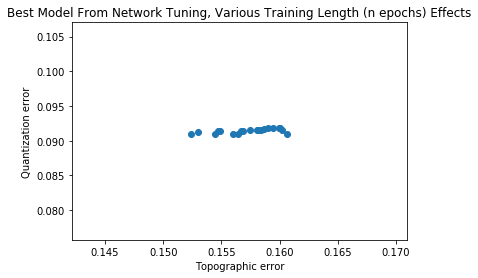

In [185]:
plt.scatter(e_top, e_q)
plt.title("Best Model From Network Tuning, Various Training Length (n epochs) Effects")
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

In [177]:
SOM_bde = joblib.load('C:\\Users\goyetc\\SOMPY\\model_mean_opt_r2_0.joblib')

In [178]:
sm.calculate_topographic_error()

0.13693188741318388

In [50]:
map_labels_k5 = sm.cluster(n_clusters=5)
data_labels_k5 = np.array([map_labels_k5[int(k)] for k in sm._bmu[0]])

In [51]:
data_labels_k5.shape

(200000L,)

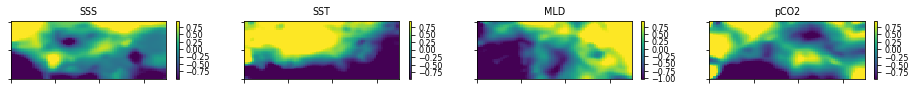

In [152]:
#top_model_n20_r20_f40_pca_rect.component_names = ['SSS','SST','MLD','pCO2']
from sompy.visualization.mapview import View2D
v2D = View2D(42,53, 'Model_18',text_size=8)  
v2D.show(top_model_n20_r20_f40_pca_rect, col_sz=4, denormalize=True) #which_dim='all' default

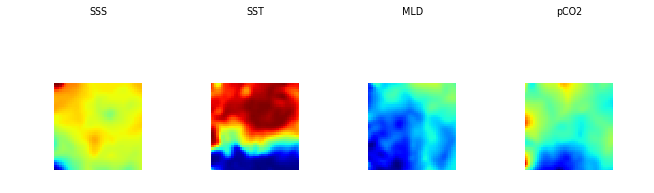

In [154]:
top_model_n20_r20_f40_pca_rect.component_names = ['SSS','SST','MLD','pCO2']
v = sompy.mapview.View2DPacked(10,10, '',text_size=8)  
v.show(top_model_n20_r20_f40_pca_rect, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default

In [75]:
SOM_sample.head()

,time,ylat,xlon,SSS,MLD,SST,pCO2
0,1991-02-15 00:00:00,-69.5,262.5,33.063404,3.040116,0.912769,256.854261
1,2004-04-16 00:00:00,-14.5,351.5,36.528145,3.996969,24.984589,378.942254
2,1993-05-16 12:00:00,65.5,355.5,35.387138,3.503074,6.933974,259.338336
3,1985-12-16 12:00:00,13.5,314.5,36.124840,4.312739,24.658592,329.150366
4,2010-09-16 00:00:00,87.5,53.5,32.139183,3.256311,-1.789207,270.250258


In [76]:
#results = top_model.find_k_nodes(ss, k=5)
#results[0].shape, results[0][:5,:]

In [99]:
map_labels_k5 = som.cluster(n_clusters=5)
data_labels_k5 = np.array([map_labels_k5[int(k)] for k in som._bmu[0]])

In [100]:
map_labels_k10 = som.cluster(n_clusters=10)
data_labels_k10 = np.array([map_labels_k10[int(k)] for k in som._bmu[0]])

In [101]:
map_labels_k15 = som.cluster(n_clusters=15)
data_labels_k15 = np.array([map_labels_k15[int(k)] for k in som._bmu[0]])

In [102]:
data_labels_k5.shape

(41035L,)

In [103]:
means['k=5'] = data_labels_k5

In [104]:
means['k=10'] = data_labels_k10

In [105]:
means['k=15'] = data_labels_k15

In [106]:
means.sample(100)

,ylat,xlon,SSS,MLD,SST,pCO2,k=5,k=10,k=15
29461,29.5,178.5,34.662872,3.954353,20.966900,347.346451,0,4,12
7369,-50.5,247.5,33.758038,4.461895,7.622427,361.350812,3,0,14
27455,20.5,59.5,35.640488,3.598347,25.519579,380.465171,1,8,9
20081,-7.5,4.5,35.117428,3.556325,26.058784,370.346113,0,4,9
8877,-45.5,2.5,33.896191,4.337421,9.011979,356.580466,3,0,14
29531,29.5,275.5,36.037632,2.636859,24.428190,347.669601,1,4,9
12646,-34.5,56.5,34.618744,3.968857,18.528402,347.749371,0,4,12
17486,-17.5,212.5,34.759830,3.919848,27.172907,333.348329,0,4,12
17136,-18.5,104.5,34.121796,4.007007,24.156637,334.496194,0,4,12
22550,1.5,124.5,33.193645,3.779031,28.738583,343.336728,0,4,9


In [108]:
means.columns

Index([u'ylat', u'xlon', u'SSS', u'MLD', u'SST', u'pCO2', u'k=5', u'k=10',
       u'k=15'],
      dtype='object')

DataFrame.to_csv(path_or_buf=None, sep=', ', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', line_terminator='\n', chunksize=None, tupleize_cols=None, date_format=None, doublequote=True, escapechar=None, decimal='.')[source]

In [110]:
means.to_csv('C:\\Users\\goyetc\\ocean-co2-absorption\\notebooks\\means_SOM.csv',
                  sep=',',
                  na_rep='NaN',
                  columns=[u'ylat', u'xlon', u'SSS', u'MLD', u'SST', u'pCO2', u'k=5', u'k=10',
       u'k=15'],
                  header=True,
                  index=True,
                  mode='w')
                  